# Mixtures de gaussiennes

In [1]:
%matplotlib notebook
#import random
#import datetime
import itertools
#from math import sqrt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#import scipy.stats as st
from scipy import linalg
from sklearn import mixture

from lib.es import open_plt, open_user

In [2]:
DATA_PATH = "data/geolife_trajectories/"

## Focus sur 3 utilisateurs

In [13]:
users = ['034', '054', '047']
nb_users = len(users)
points = []
min_lon = []
max_lon = []
min_lat = []
max_lat = []
for user in users:
    user_points = np.array(open_user(DATA_PATH+user+"/Trajectory"))[:, 0:2].astype('float64')
    user_points[:,[0,1]] = user_points[:, [1,0]]
    points.append(user_points)
    #lat = points[:, 1]
    #lon = points[:, 0]
    min_lon.append(user_points[:, 0].min())
    max_lon.append(user_points[:, 0].max())
    min_lat.append(user_points[:, 1].min())
    max_lat.append(user_points[:, 1].max())

<IPython.core.display.Javascript object>


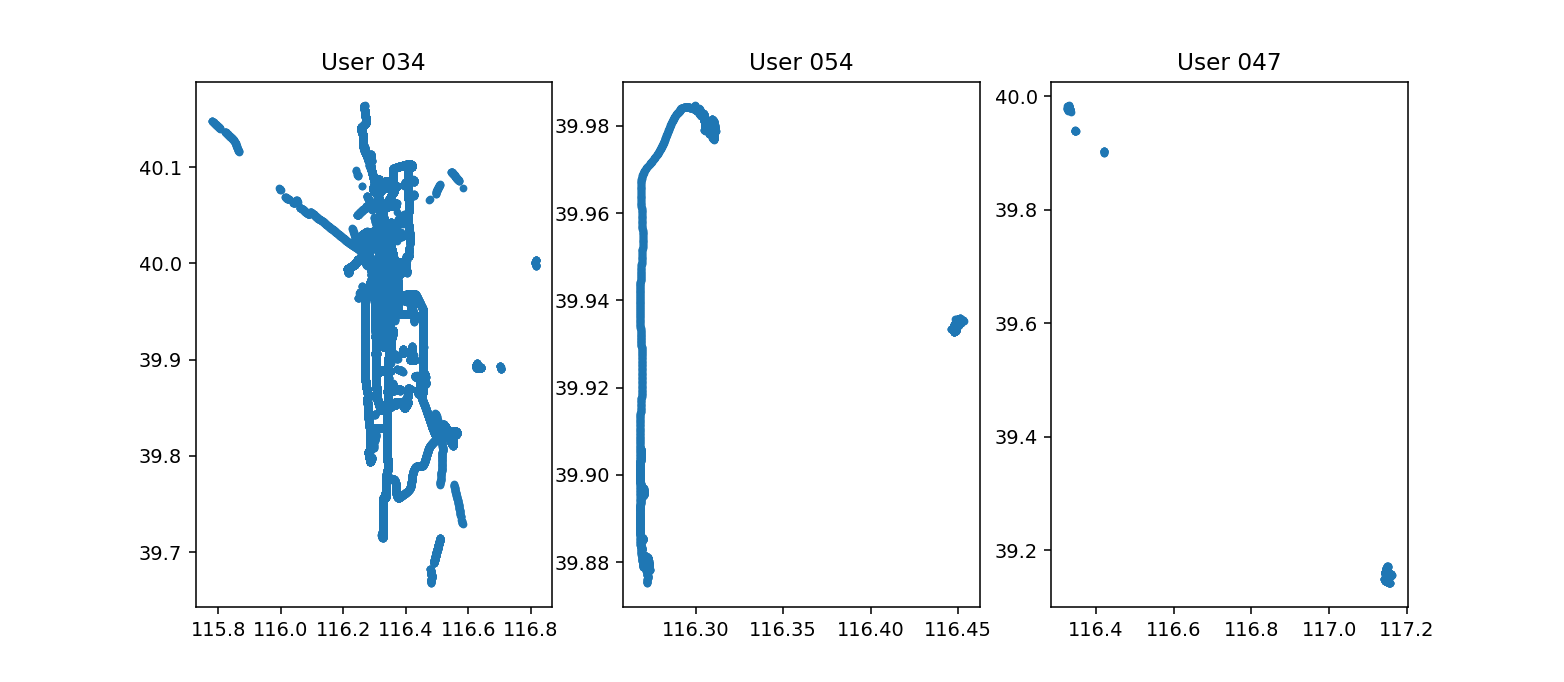

In [4]:
plt.figure()

for i in range(nb_users):
    plt.subplot(1, nb_users, i+1)
    plt.title("User "+ users[i])
    plt.plot(points[i][:, 0], points[i][:, 1], '.')

## Utilisation d'un modèle « mixture de gaussiennes »
En utilisant les modules de scikit learn :   
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.
Scikit-learn implements different classes to estimate Gaussian mixture models, that correspond to different estimation strategies :
* Gaussian Mixture : the GaussianMixture object implements the expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models. It can also draw confidence ellipsoids for multivariate models, and compute the Bayesian Information Criterion to assess the number of clusters in the data. A GaussianMixture.fit method is provided that learns a Gaussian Mixture Model from train data. Given test data, it can assign to each sample the Gaussian it mostly probably belong to using the GaussianMixture.predict method.
* Variational Bayesian Gaussian Mixture : implémente une extension de l'algorithme EM.

On s'intéresse au premier uniquement. L'algorithme de maximisation de la vraisemblance est donc déjà implémenté, cependant on doit choisir correctement le nombre de gaussiennes. Plus on ajoute de gaussiennes meilleur le maximum de vraisemblance sera, ce qui n'aide pas à distinguer les zones intéressantes, et tous les points seront inclus… (on pourrait définir une valeur fixe exemple 7 pour le nombre de gaussiennes et ne garder que les 3 (et leurs points) qui ont le meilleur maximum de vraisemblance, et ensuite faire un modèle de markov facilement en utilisant le temps associé à chaque point. Lorsque le point suivant reste dans la même zone on peut décider de ne pas le compter… => *à voir plus tard*)   

Comment choisir le nombre de gaussiennes ?
1. Faire un apprentissage de GMM sur une partie des points et tester la vraisemblance (fournie par le GMM) sur le reste pour des nombre différents de gaussienne.
2. Utiliser le BIC (Bayesian information criterion, fourni par le GMM ; ln(n)k - 2ln(L). L max de vraisemblance, n nombre de points, k nombre de paramètres appris, (1+d+d²) par gaussienne avec d la dimension : 1 pour π, d pour les µ, d² les pour σ (matrice de covariance Σ de dim d²). Ici : 7 paramètres). Pertinent dans notre cas ? 

### 1. Train/Test

In [ ]:
nb_max_gaussiennes = 20
proportion_train = 0.8

scores = []
meilleur_score = []
meilleur_gmm = []

for i in range(nb_users):
    print('\nUser',users[i], end=' ')
    points_melanges = points[i][np.random.permutation(points[i].shape[0])]
    train = points_melanges[:int(proportion_train*len(points[i]))]
    test  = points_melanges[int(proportion_train*len(points[i])):]
    
    meilleur_score.append(0)
    meilleur_gmm.append(0)
    for n_components in range(1, nb_max_gaussiennes+1):
        # Fit a Gaussian mixture with EM
        print(n_components, 'gaussiennes', end=' ')
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
        gmm.fit(train)
        scores.append(gmm.score(test))
        print('score =', scores[-1], end=' ')
        if scores[-1] > meilleur_score[i]:
            meilleur_score[i] = scores[-1]
            meilleur_gmm[i] = gmm
scores = np.array(scores).reshape(nb_users, nb_max_gaussiennes).T

In [64]:
meilleur_score

[4.3246022821633447, 9.006408257388852, 8.7788322800368519]

<IPython.core.display.Javascript object>


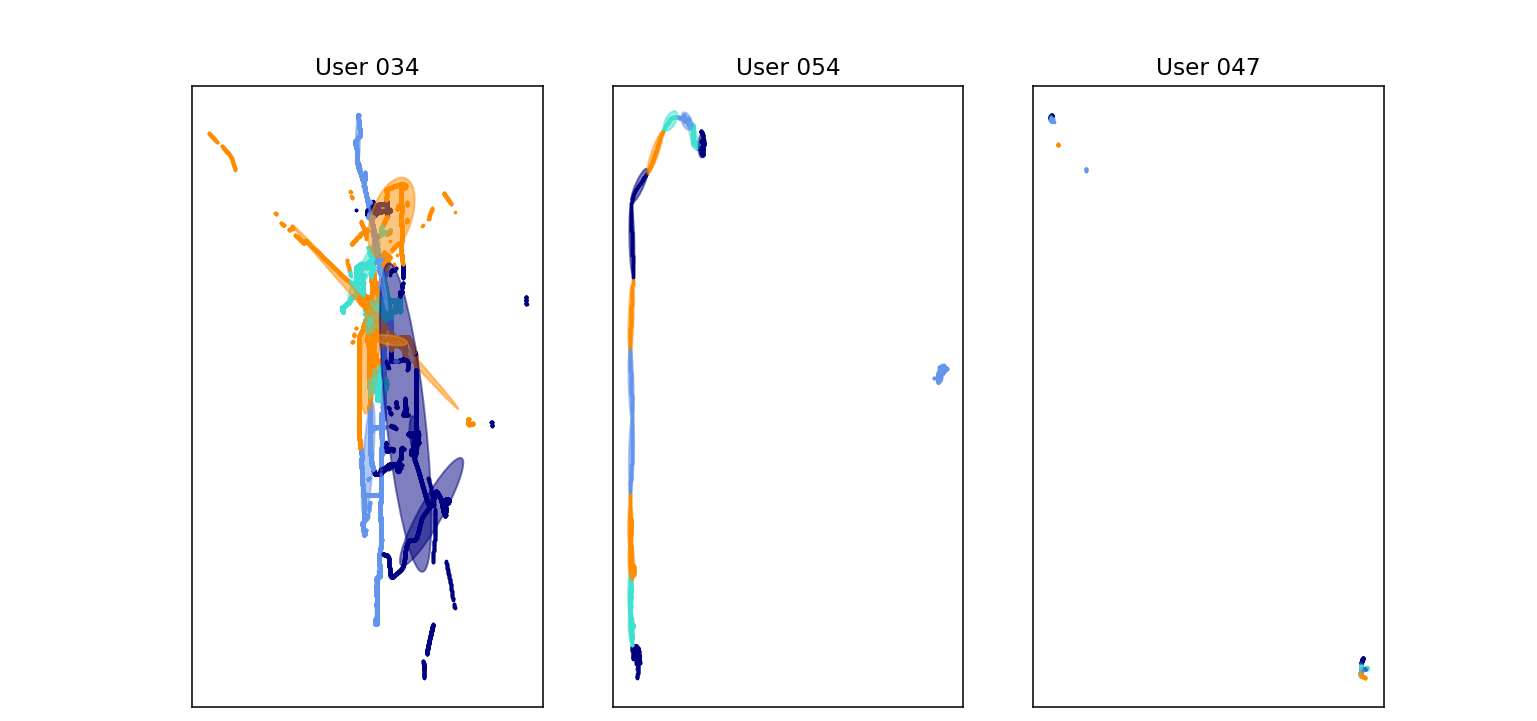

In [76]:
plt.figure()
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

for i in range(nb_users):
    splot = plt.subplot(1, nb_users, i+1)
    X = points[i]
    clf = meilleur_gmm[i]
    
    Y_ = clf.predict(X)
    for j, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == j):
            continue
        plt.scatter(X[Y_ == j, 0], X[Y_ == j, 1], .8, color=color)
    
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)
    
    plt.xticks(())
    plt.yticks(())
    plt.title('User '+users[i])
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.show()

### 2. BIC

In [118]:
nb_max_gaussiennes = 10
cv_types = ['spherical', 'tied', 'diag', 'full']

bics = []
meilleur_bic = []
meilleur_gmm = []

for i in range(nb_users):
    print('\nUser',users[i], end=' ')
    X = points[i]

    meilleur_bic.append(np.infty)
    meilleur_gmm.append(0)
    
    for cv_type in cv_types:
        print('cv type:', cv_type, end=' ')
        for n_components in range(1, nb_max_gaussiennes+1):
            print(n_components, "gaussiennes", end=' ')
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
            gmm.fit(X)
            bics.append(gmm.bic(X))
            #print('bic = ', bics[-1], end=' ')
            if bics[-1] < meilleur_bic[i]:
                meilleur_bic[i] = bics[-1]
                meilleur_gmm[i] = gmm

bics_temp = bics
bics = np.array(bics).reshape(nb_users, len(cv_types), nb_max_gaussiennes)


User 034 cv type: spherical 1 gaussiennes 2 gaussiennes 3 gaussiennes 4 gaussiennes 5 gaussiennes 6 gaussiennes 7 gaussiennes 8 gaussiennes 9 gaussiennes 10 gaussiennes cv type: tied 1 gaussiennes 2 gaussiennes 3 gaussiennes 4 gaussiennes 5 gaussiennes 6 gaussiennes 7 gaussiennes 8 gaussiennes 9 gaussiennes 10 gaussiennes cv type: diag 1 gaussiennes 2 gaussiennes 3 gaussiennes 4 gaussiennes 5 gaussiennes 6 gaussiennes 7 gaussiennes 8 gaussiennes 9 gaussiennes 10 gaussiennes cv type: full 1 gaussiennes 2 gaussiennes 3 gaussiennes 4 gaussiennes 5 gaussiennes 6 gaussiennes 7 gaussiennes 8 gaussiennes 9 gaussiennes 10 gaussiennes 
User 054 cv type: spherical 1 gaussiennes 2 gaussiennes 3 gaussiennes 4 gaussiennes 5 gaussiennes 6 gaussiennes 7 gaussiennes 8 gaussiennes 9 gaussiennes 10 gaussiennes cv type: tied 1 gaussiennes 2 gaussiennes 3 gaussiennes 4 gaussiennes 5 gaussiennes 6 gaussiennes 7 gaussiennes 8 gaussiennes 9 gaussiennes 10 gaussiennes cv type: diag 1 gaussiennes 2 gaussienne

In [120]:
bics_temp2= np.array(bics_temp).reshape(nb_users, len(cv_types)*nb_max_gaussiennes)

In [126]:
bics_temp2[0]

array([ -925192.64224637, -1048067.480156  , -1065171.00990948,
       -1074163.81868589, -1162632.49877306, -1171741.33263814,
       -1174938.77032047, -1174154.1796305 , -1179438.05027939,
       -1200237.45942837,  -960821.24461619,  -997017.12538292,
        -996297.28634272, -1031120.45602142, -1056096.3540861 ,
       -1041045.63678027, -1051244.18930636, -1046445.11872162,
       -1063303.67586465, -1087901.92878519,  -948582.76799444,
       -1069810.43046333, -1126966.34187807, -1136780.99377207,
       -1192563.3237268 , -1148398.31423627, -1213721.91205698,
       -1220962.48940004, -1240197.33781382, -1263548.77856087,
        -960821.24461281, -1078463.46642436, -1103843.30306527,
       -1212543.5494418 , -1232324.10779361, -1239558.32884302,
       -1256682.70803021, -1255931.96622978, -1284849.40364434,
       -1302060.72337971])

In [115]:
np.min(bics[0])

-1304475.127591457

In [111]:
meilleur_bic

[-1304475.127591457, -85475.292610544086, -13414.33202096407]

<IPython.core.display.Javascript object>


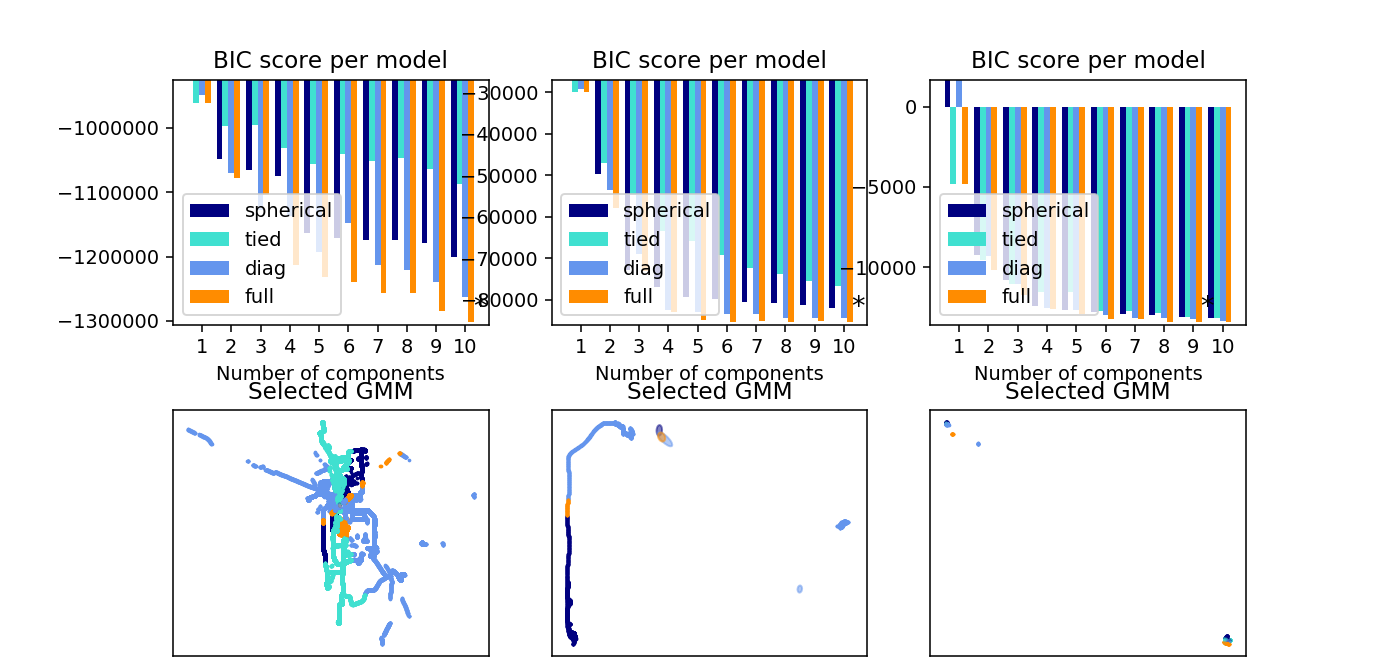

In [129]:
plt.figure()
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

for j in range(nb_users):
    bars = []
    bic = bics_temp2[j]
    # Plot the BIC scores
    spl = plt.subplot(2, nb_users, j+1)
    plt.title("User "+users[j]+" BIC")
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(range(1, nb_max_gaussiennes+1)) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * nb_max_gaussiennes:(i + 1) * nb_max_gaussiennes], width=.2, color=color))
    plt.xticks(range(1, nb_max_gaussiennes+1))
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), nb_max_gaussiennes) + .65 +.2 * np.floor(bic.argmin() / nb_max_gaussiennes)
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

    # Plot the winner
    splot = plt.subplot(2, nb_users, j+4)
    X = points[j]
    Y_ = clf.predict(X)
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
    
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)
    
    plt.xticks(())
    plt.yticks(())
    plt.title('Selected GMM')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.show()

### Tests

<IPython.core.display.Javascript object>


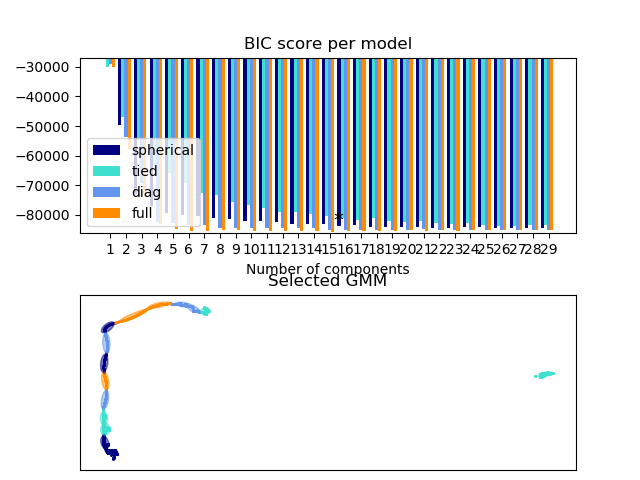

In [20]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        splot.plot(mean[0], mean[1], 'ro')
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(lon_min, lon_max)
    plt.ylim(lat_min, lat_max)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

    
X = points
# Fit a Gaussian mixture with EM using three components
lowest_bic = np.infty
bic = []
scores = []
n_components_range = range(1, 30)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        scores.append(gmm.score(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +.2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()
            
            
#gmm = mixture.GaussianMixture(n_components=8, covariance_type='full').fit(X)
#plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using three components
#dpgmm = mixture.BayesianGaussianMixture(n_components=6,
#                                        covariance_type='full').fit(X)
#plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
#             'Bayesian Gaussian Mixture with a Dirichlet process prior')
#
#plt.show()

In [27]:
np.array(scores).reshape(4,29)

array([[ 2.8161815 ,  5.19274157,  7.63270937,  8.06216489,  8.30800771,
         8.37708857,  8.44210674,  8.5019219 ,  8.53562164,  8.61806468,
         8.6384346 ,  8.66317276,  8.7453181 ,  8.72242426,  8.74898788,
         8.82083519,  8.78657694,  8.8552569 ,  8.86468076,  8.87618341,
         8.87666753,  8.89561763,  8.90382917,  8.89515501,  8.89926309,
         8.91005954,  8.91805362,  8.91750109,  8.92675891],
       [ 3.13567027,  4.92437862,  5.74549423,  6.64708918,  6.9078885 ,
         7.26540017,  7.59795306,  7.70173717,  7.92514655,  8.0626018 ,
         8.15712667,  8.29640933,  8.30542503,  8.37876497,  8.46433326,
         8.51017549,  8.58245756,  8.54233618,  8.61838595,  8.67834861,
         8.63171197,  8.72527068,  8.74326492,  8.73506981,  8.80760937,
         8.8290419 ,  8.83362605,  8.81659785,  8.81255795],
       [ 3.04332732,  5.60800054,  7.23845051,  8.64294736,  8.68983938,
         8.75316862,  8.75872259,  8.85458021,  8.86148939,  8.86481632,
  

# Exemples sur internet

<IPython.core.display.Javascript object>


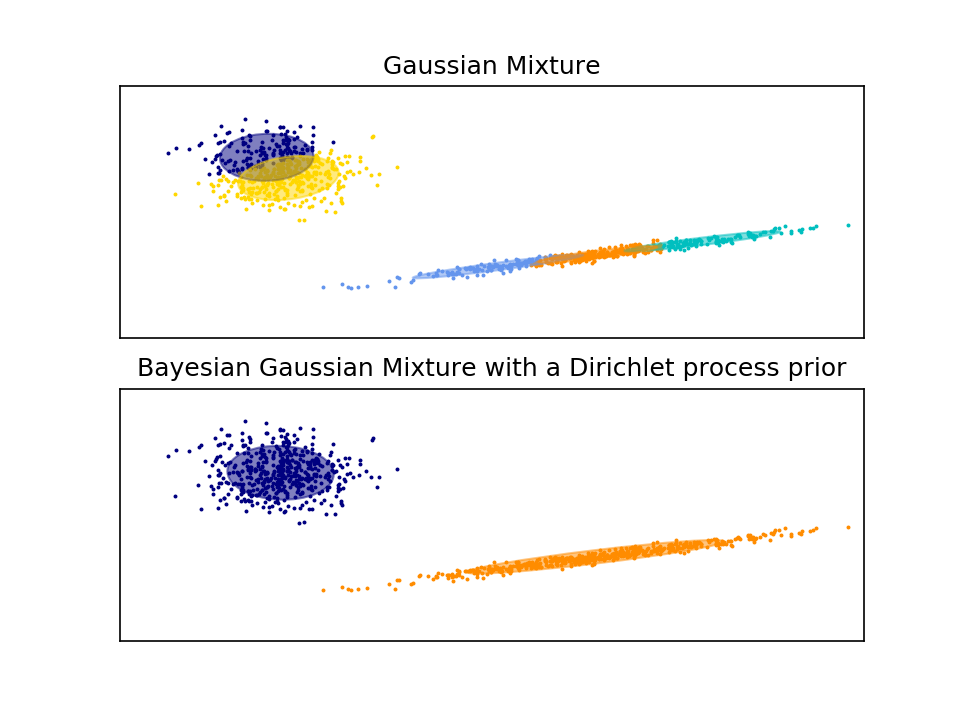

In [4]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

<IPython.core.display.Javascript object>


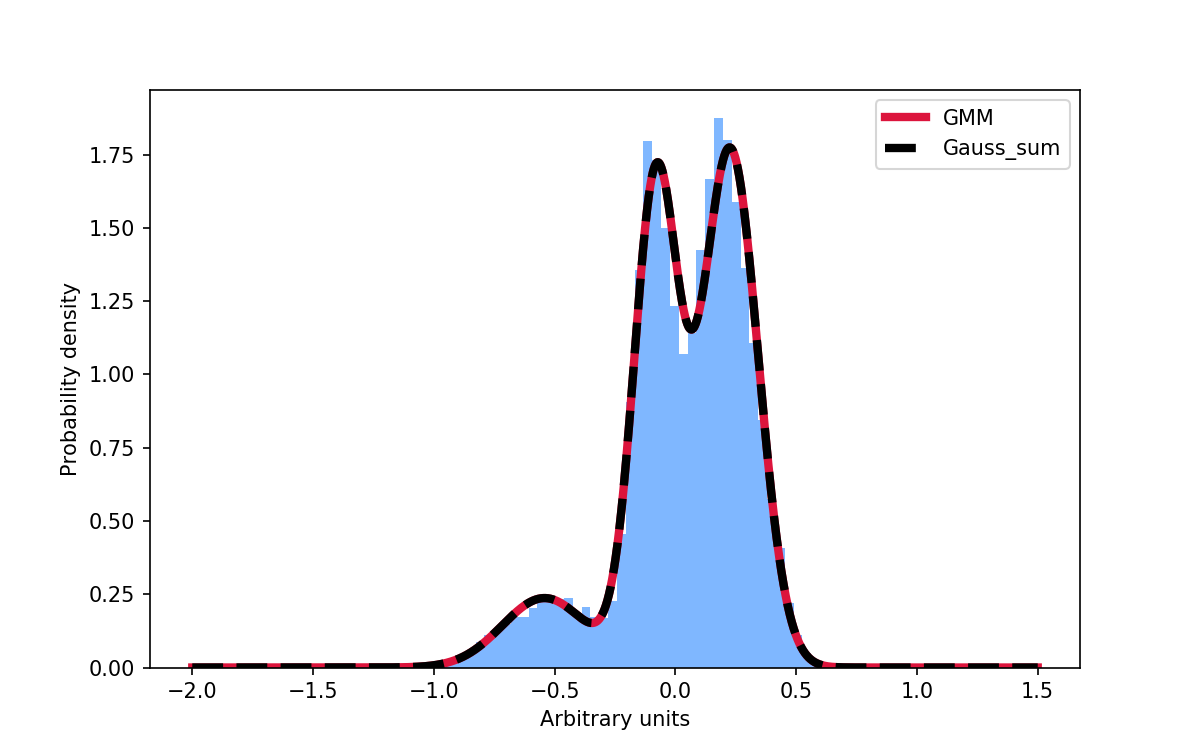

In [5]:
# Define simple gaussian
def gauss_function(x, amp, x0, sigma):
    return amp * np.exp(-(x - x0) ** 2. / (2. * sigma ** 2.))

# Generate sample from three gaussian distributions
samples = np.random.normal(-0.5, 0.2, 2000)
samples = np.append(samples, np.random.normal(-0.1, 0.07, 5000))
samples = np.append(samples, np.random.normal(0.2, 0.13, 10000))

# Fit GMM
gmm = GaussianMixture(n_components=3, covariance_type="full", tol=0.001)
gmm = gmm.fit(X=np.expand_dims(samples, 1))

# Evaluate GMM
gmm_x = np.linspace(-2, 1.5, 5000)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1, 1)))

# Construct function manually as sum of gaussians
gmm_y_sum = np.full_like(gmm_x, fill_value=0, dtype=np.float32)
for m, c, w in zip(gmm.means_.ravel(), gmm.covariances_.ravel(), gmm.weights_.ravel()):
    gauss = gauss_function(x=gmm_x, amp=1, x0=m, sigma=np.sqrt(c))
    gmm_y_sum += gauss / np.trapz(gauss, gmm_x) * w

# Make regular histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.hist(samples, bins=50, normed=True, alpha=0.5, color="#0070FF")
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")
ax.plot(gmm_x, gmm_y_sum, color="black", lw=4, label="Gauss_sum", linestyle="dashed")

# Annotate diagram
ax.set_ylabel("Probability density")
ax.set_xlabel("Arbitrary units")

# Make legend
plt.legend()

plt.show()

## Sur le dataframe user 001
On choisit un nombre fixe de gaussiennes ex 15

In [16]:
import pandas as pd

In [17]:
df_001_ip = pd.read_pickle(DATA_PATH+'001/dataframe_5s_ip.pkl')

In [18]:
points = np.array(df_001_ip)

In [35]:
len(points)

911979

In [19]:
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full')
gmm.fit(points)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [49]:
sorted(gmm.weights_)[-1]

0.48850005121603396

<IPython.core.display.Javascript object>


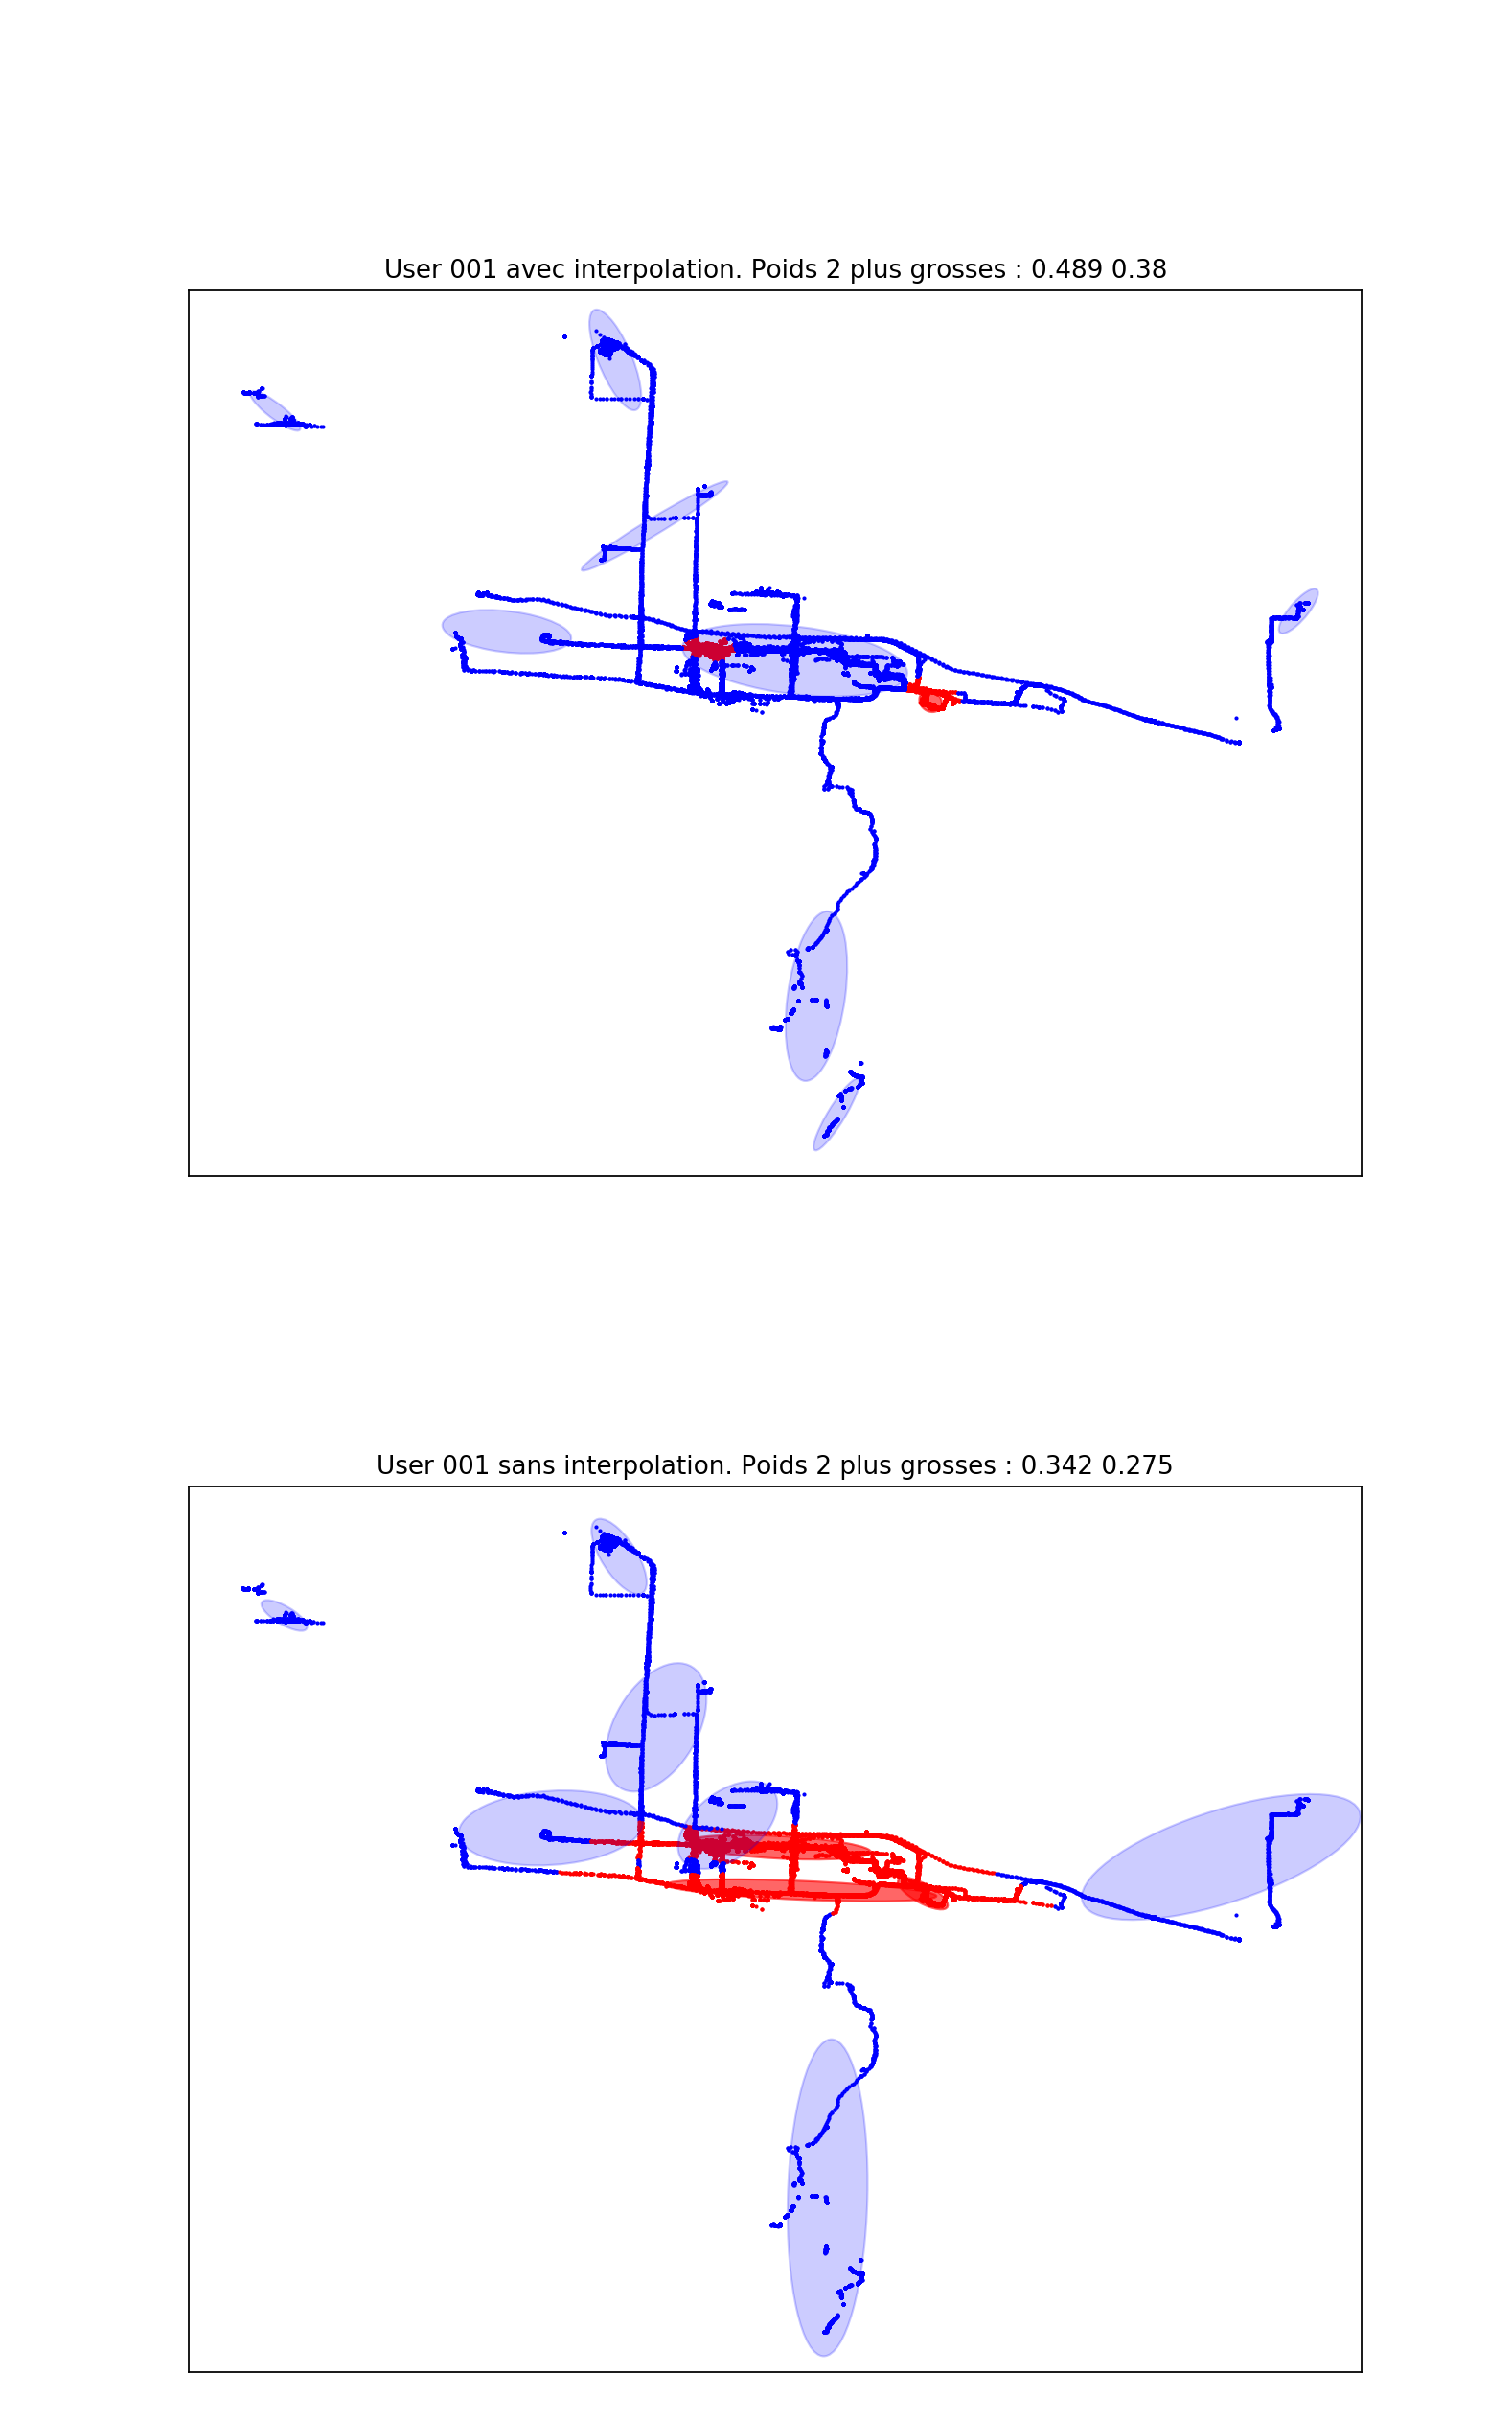

In [54]:
plt.figure(num=5, figsize=(10, 16))
plt.clf()
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

splot = plt.subplot(2, 1, 1)
X = points
clf = gmm
    
Y_ = clf.predict(X)
for j, (mean, cov, weight) in enumerate(zip(clf.means_, clf.covariances_, clf.weights_)):
    if weight > 0.1:
        color = 'red'
    else:
        color = 'blue'
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == j):
        continue
    plt.scatter(X[Y_ == j, 0], X[Y_ == j, 1], .8, color=color)
    
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
            
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    if weight > 0.1:
        ell.set_alpha(.6)
    else:
        ell.set_alpha(.2)
    splot.add_artist(ell)
    
plt.xticks(())
plt.yticks(())
plt.title('User 001 avec interpolation. Poids 2 plus grosses : '+str(round(sorted(gmm.weights_)[-1], 3))+' '+str(round(sorted(gmm.weights_)[-2],3)))
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

## Idem mais sur les données de 001 sans interpolation

In [30]:
pos = np.load(DATA_PATH+'001/ndarray_lat_lon.npy')

In [36]:
len(pos)

108607

In [31]:
gmm2 = mixture.GaussianMixture(n_components=10, covariance_type='full')
gmm2.fit(pos)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

<IPython.core.display.Javascript object>


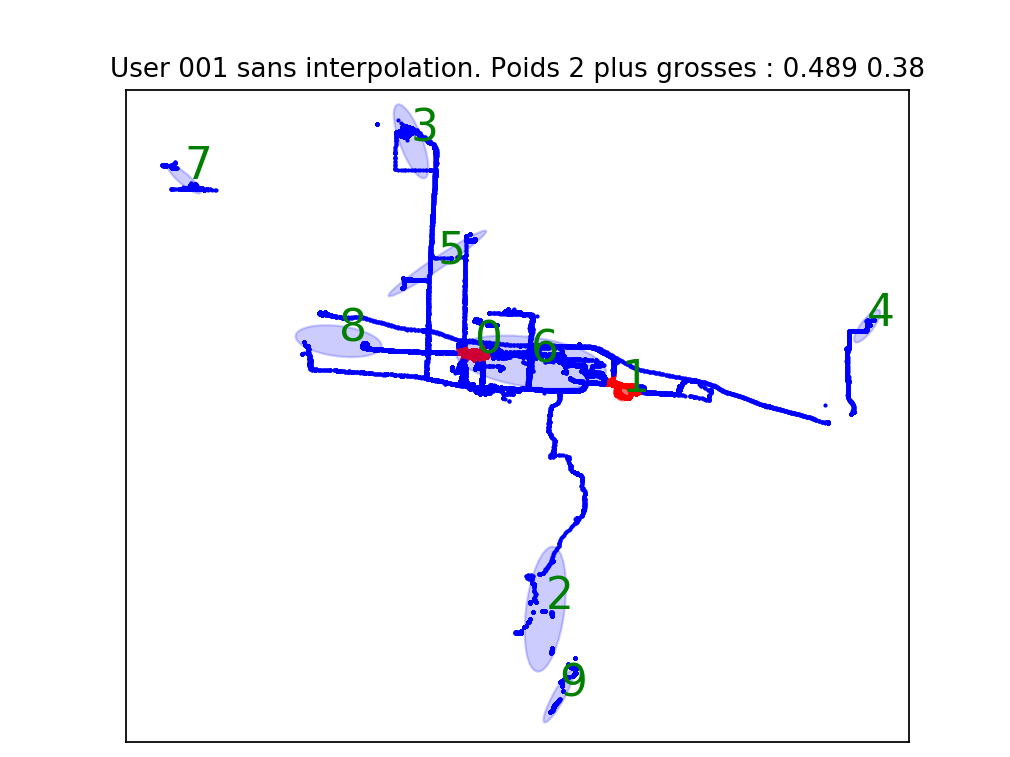

In [59]:
plt.figure(6)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

splot = plt.subplot(1, 1, 1)
X = points
clf = gmm
    
Y_ = clf.predict(X)
for j, (mean, cov, weight) in enumerate(zip(clf.means_, clf.covariances_, clf.weights_)):
    if weight > 0.1:
        color = 'red'
    else:
        color = 'blue'
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == j):
        continue
    plt.scatter(X[Y_ == j, 0], X[Y_ == j, 1], .8, color=color)
    
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
            
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    if weight > 0.1:
        ell.set_alpha(.6)
    else:
        ell.set_alpha(.2)
    splot.add_artist(ell)
    plt.annotate(str(j), xy = mean, xytext = mean, color = 'green', fontsize=20)
plt.xticks(())
plt.yticks(())
plt.title('User 001 sans interpolation. Poids 2 plus grosses : '+str(round(sorted(clf.weights_)[-1], 3))+' '+str(round(sorted(clf.weights_)[-2],3)))
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [61]:
import hmmlearn

ModuleNotFoundError: No module named 'hmmlearn'